Paul Gasper, Ph.D., National Renewable Energy Lab, 2024

Paul.Gasper@nrel.gov

Examples of simulating EV lifetime for personal and commercial vehicles based on assumed driving profiles.
These simulations are not meant to comment on real-world EVs. Battery life models are dependent on battery-specific degradation data, and the driving profiles were created as illustrative examples and are not representative of real world driving data.

The climate chosen in this example is Honolulu, Hawai'i, which has a very stable climate in a temperature range that is optimal for many commercial lithium-ion batteries. As this simulation is not addressing thermal management of the vehicle battery in any way, any simulations for climates with extreme heat or extreme cold will not be an accurate representation of most real world EVs, which can cool and sometimes heat the battery pack to maintain safe and reliable battery performance in a wide temperature range.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from blast.utils.functions import get_nsrdb_temperature_data

Text(0, 0.5, 'Temperature (C)')

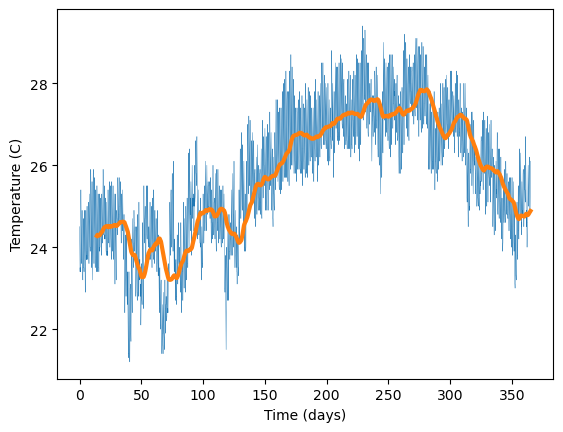

In [7]:
# climate = get_nsrdb_temperature_data('Honolulu, Hawaii') # Openstreetmap doesn't always respond
climate = pd.read_csv('climates/nsrdb_honolulu.csv')
plt.plot(climate['Time_s']/(3600*24), climate['Temperature_C'], linewidth=0.3)
plt.plot(climate['Time_s']/(3600*24), climate['Temperature_C'].rolling(14*24*2).mean(), linewidth=3)
plt.xlabel('Time (days)')
plt.ylabel('Temperature (C)')

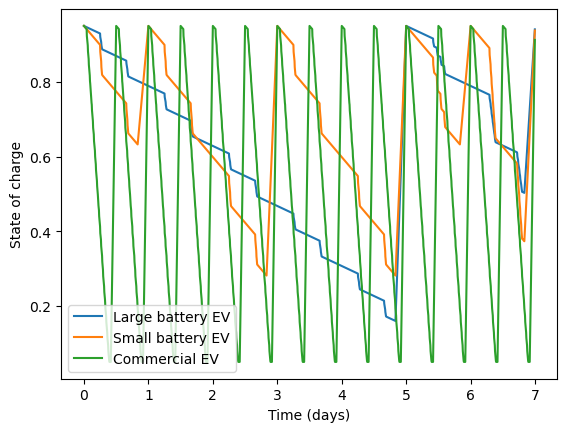

In [14]:
ev_largebattery = pd.read_csv('application profiles/Electric vehicle/personal_ev_largebatt.csv')
ev_smallbattery = pd.read_csv('application profiles/Electric vehicle/personal_ev_smallbatt.csv')
commercial_ev = pd.read_csv('application profiles/Electric vehicle/commercial_ev.csv')

plt.plot(ev_largebattery['Time_s'] / (24*3600), ev_largebattery['SOC'], label='Large battery EV')
plt.plot(ev_smallbattery['Time_s'] / (24*3600), ev_smallbattery['SOC'], label='Small battery EV')
plt.plot(commercial_ev['Time_s'] / (24*3600), commercial_ev['SOC'], label='Commercial EV')
plt.xlabel('Time (days)')
plt.ylabel('State of charge')
plt.legend()

In [16]:
from blast.utils.functions import assemble_one_year_input
input_ev_smallbatt = assemble_one_year_input(ev_smallbattery, climate)
input_ev_largebatt = assemble_one_year_input(ev_largebattery, climate)
input_ev_commercial = assemble_one_year_input(commercial_ev, climate)

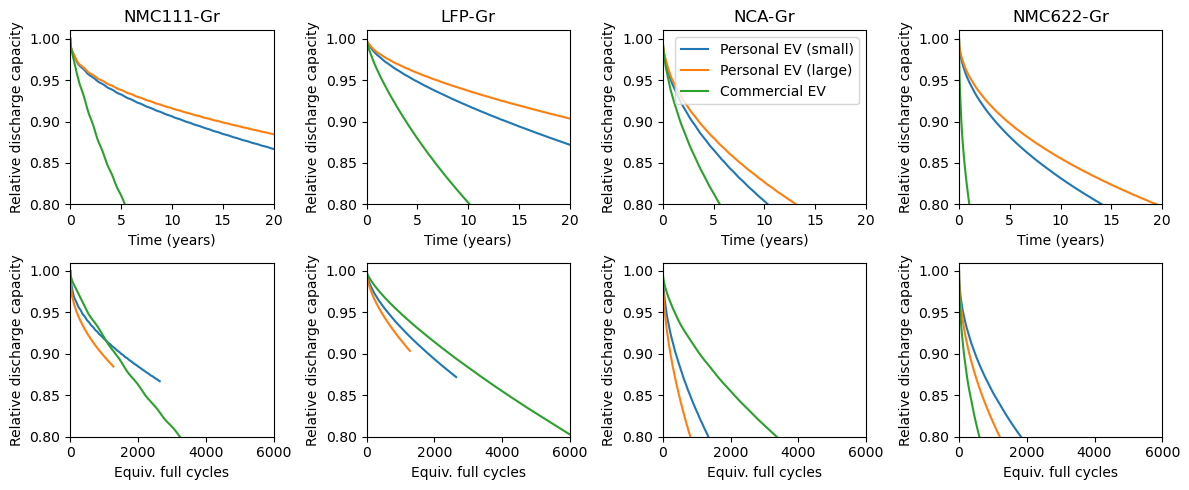

In [17]:
from blast.models.nmc111_gr_Kokam75Ah_2017 import Nmc111_Gr_Kokam75Ah_Battery
from blast.models.lfp_gr_250AhPrismatic_2019 import Lfp_Gr_250AhPrismatic
from blast.models.nca_gr_Panasonic3Ah_2018 import Nca_Gr_Panasonic3Ah_Battery
from blast.models.nmc622_gr_DENSO50Ah_2021 import Nmc622_Gr_DENSO50Ah_Battery

batteries = {
    'NMC111-Gr': [Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery()],
    'LFP-Gr': [Lfp_Gr_250AhPrismatic(), Lfp_Gr_250AhPrismatic(), Lfp_Gr_250AhPrismatic()],
    'NCA-Gr': [Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery()],
    'NMC622-Gr': [Nmc622_Gr_DENSO50Ah_Battery(), Nmc622_Gr_DENSO50Ah_Battery(), Nmc622_Gr_DENSO50Ah_Battery()]
}
simulations = {
    'Personal EV (small)': input_ev_smallbatt,
    'Personal EV (large)': input_ev_largebatt,
    'Commercial EV': input_ev_commercial,
}

years_simulation = 20
fig, ax = plt.subplots(2, 4, figsize=(12,5))
idx_ax = 0
for batt_type, battery in batteries.items():
    idx_sim = 0
    for sim_type, sim_input in simulations.items():
        batt = battery[idx_sim]
        batt.simulate_battery_life(sim_input, threshold_time=years_simulation)

        ax[0][idx_ax].plot(batt.stressors['t_days']/365, batt.outputs['q'], label=sim_type)
        ax[1][idx_ax].plot(batt.stressors['efc'], batt.outputs['q'], label=sim_type)
        idx_sim += 1
        
    ax[0][idx_ax].set_xlabel('Time (years)')
    ax[0][idx_ax].set_ylabel('Relative discharge capacity')
    ax[0][idx_ax].set_ylim((0.8, 1.01))
    ax[0][idx_ax].set_xlim((0, 20))
    ax[1][idx_ax].set_xlabel('Equiv. full cycles')
    ax[1][idx_ax].set_ylabel('Relative discharge capacity')
    ax[1][idx_ax].set_ylim((0.8, 1.01))
    ax[1][idx_ax].set_xlim((0, 6000))

    ax[0][idx_ax].set_title(batt_type)
    if idx_ax == 2:
        ax[0][idx_ax].legend(loc='upper right')
    idx_ax += 1

plt.tight_layout()

While 'equivalent full cycles' is a nice measure for battery use, real-world vehicle use is in units of 'vehicle miles traveled', or VMT. To turn VMT into equivalent full cycles, we can make a simple assumption that the vehicle's pack range is equal to one full discharge, e.g., half an equivalent full cycle. US Department of Transporation data is used to get a cumulative distribution function of annual VMTs to simulate the distribution of personal vehicle battery degradation paths; this data is compiled from data on population groups segregated by age and gender, so the 100-percentile annual VMT is not representative of an individual, which could be much higher. Also, this data is for personal vehicles, not commercial vehicles. To convert annual VMT into equivalent full cycles, I assume pack sizes from Tesla Model 3 Short Range for LFP-Gr, and Tesla Model 3 Long Range for the higher energy density layered oxides.

<Axes: xlabel='CDF'>

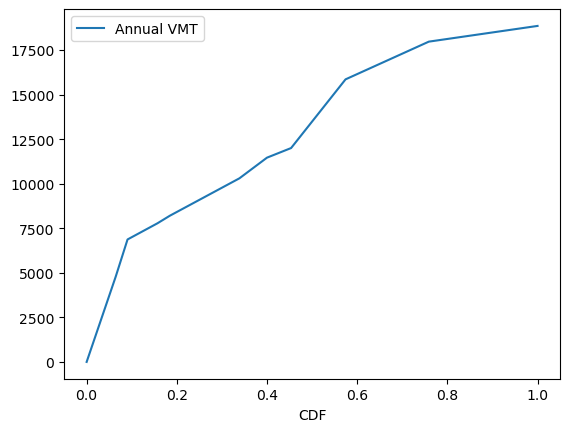

In [27]:
annual_vmt = pd.read_csv("application profiles/Electric vehicle/annual_vmt_cdf.csv")
annual_vmt.plot(x='CDF', y='Annual VMT')

<Axes: xlabel='Time_s'>

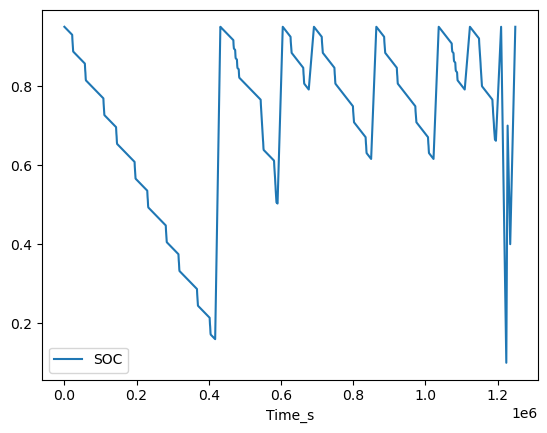

In [29]:
# To represent varied vehicle driving patterns, use to 'combined' vehicle SOC profile
ev_combined = pd.read_csv('application profiles/Electric vehicle/personal_ev_combined.csv')
ev_combined.plot(x='Time_s', y='SOC')

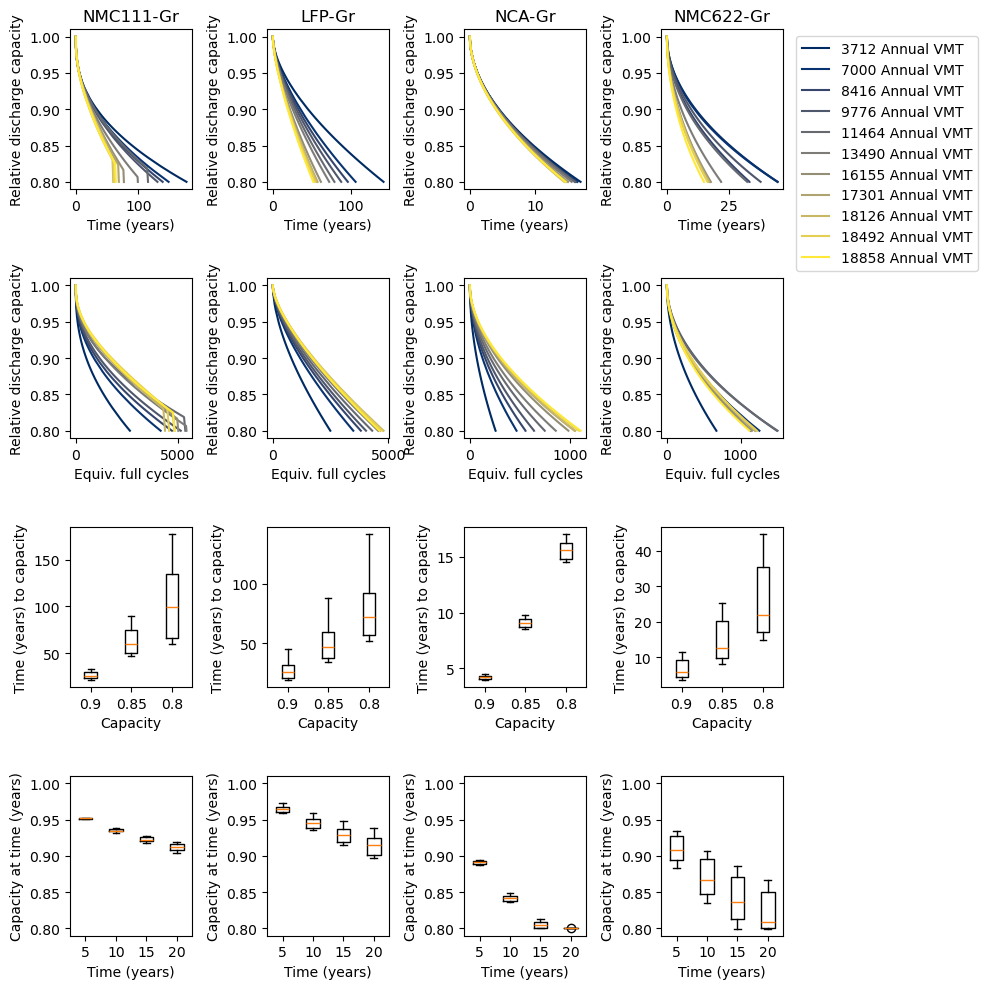

In [33]:
# To scale any vehicle profile to a certain number of annual EFCs, there is a helper function
# This function takes any vehicle SOC profile and adds either rests or deep-discharge driving events
# to reduce or increase the annual EFCs to hit the targeted value.
from blast.utils.functions import scale_vehicle_profile_to_annual_efcs

batteries = ['NMC111-Gr', 'LFP-Gr', 'NCA-Gr', 'NMC622-Gr']
"""
LFP (Model 3 short range): 
- 272 mile EPA range * 77% performance = 209.4 miles/EFC 
- 209.4 miles/EFC = 64 EFCs/year @ 13476 miles/yr
- 60.9 kWh energy capacity

NMC/NCA (Model 3 long range): 
- 363 mile EPA range * 67% performance = 243.2 miles/EFC
- 243.2 miles/EFC = 55 EFCs/year @ 13476 miles/yr
- 82 kWh energy capacity
"""
percentiles = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
from cycler import cycler
cmap = plt.get_cmap('cividis')
fig, ax = plt.subplots(4, 4, figsize=(10,10))
for axis in ax.ravel():
    axis.set_prop_cycle(cycler('color', cmap(percentiles)))
idx_ax = 0
for battery in batteries:
    idx_sim = 0
    time_to_capacity = {
        0.9: [],
        0.85: [],
        0.8: [],
    }
    capacity_at_time = {
        5: [],
        10: [],
        15: [],
        20: [],
    }

    for percentile in percentiles:
        vmt = np.interp(percentile, annual_vmt['CDF'], annual_vmt['Annual VMT'])
        if battery == 'LFP-Gr':
            efcs = vmt / 209.4
            ev = scale_vehicle_profile_to_annual_efcs(ev_combined.copy(), desired_efcs_per_year=efcs)
            batt = Lfp_Gr_250AhPrismatic()
        else:
            efcs = vmt / 243.2
            ev = scale_vehicle_profile_to_annual_efcs(ev_combined.copy(), desired_efcs_per_year=efcs)
            if battery == 'NCA-Gr':
                batt = Nca_Gr_Panasonic3Ah_Battery()
            elif battery == 'NMC111-Gr':
                batt = Nmc111_Gr_Kokam75Ah_Battery()
            elif battery == 'NMC622-Gr':
                batt = Nmc622_Gr_DENSO50Ah_Battery()
            
        
        ev['Temperature_C'] = 20
        batt.simulate_battery_life(ev, threshold_capacity=0.8)   

        ax[0][idx_ax].plot(batt.stressors['t_days']/365, batt.outputs['q'], label=f"{int(vmt)} Annual VMT")
        ax[1][idx_ax].plot(batt.stressors['efc'], batt.outputs['q'], label=f"{int(vmt)} Annual VMT")
        idx_sim += 1

        # For each 'capacity' in 'time_to_capacity', extract the years to that capacity and append
        for capacity, years in time_to_capacity.items():
            idx = np.argwhere(np.array(batt.outputs['q']) < capacity).flatten()
            if len(idx) > 0:
                years.append(batt.stressors['t_days'][idx[0]] / 365)
            else:
                years.append(np.nan)
        # For each 'time' in 'capacity_at_time', extract the capacity at that time and append
        for time, capacities in capacity_at_time.items():
            idx = np.argwhere(batt.stressors['t_days'] / 365 < time).flatten()
            if len(idx) > 0:
                capacities.append(batt.outputs['q'][idx[-1]])
            else:
                capacities.append(np.nan)

    # Plot boxplots of time_to_capacity on row 2
    ax[2][idx_ax].boxplot(time_to_capacity.values(), tick_labels=time_to_capacity.keys())
    ax[2][idx_ax].set_ylabel('Time (years) to capacity')
    ax[2][idx_ax].set_xlabel('Capacity')
    # Plot boxplots of capacity_at_time on row 3
    ax[3][idx_ax].boxplot(capacity_at_time.values(), tick_labels=capacity_at_time.keys())  
    ax[3][idx_ax].set_ylabel('Capacity at time (years)')  
    ax[3][idx_ax].set_xlabel('Time (years)')
    ax[3][idx_ax].set_ylim((0.79, 1.01))
    
    ax[0][idx_ax].set_xlabel('Time (years)')
    ax[0][idx_ax].set_ylabel('Relative discharge capacity')
    ax[0][idx_ax].set_ylim((0.79, 1.01))
    # ax[0][idx_ax].set_xlim((0, 20))
    ax[1][idx_ax].set_xlabel('Equiv. full cycles')
    ax[1][idx_ax].set_ylabel('Relative discharge capacity')
    ax[1][idx_ax].set_ylim((0.79, 1.01))
    # ax[1][idx_ax].set_xlim((0, 6000))

    ax[0][idx_ax].set_title(battery)
    if idx_ax == 3:
        ax[0][idx_ax].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    idx_ax += 1

plt.tight_layout()